In [323]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import torch.optim as optim
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as mse 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [324]:
df = pd.read_csv("co2_mm_mlo.csv",skiprows=range(40))
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


In [325]:
y=df['average'].to_numpy()
X=np.arange(1,len(y)+1)

In [326]:
split = int(0.8 * len(y))
X_train=X[:split]
X_test=X[split:]
y_train=y[:split]
y_test=y[split:]

In [327]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=4)

In [328]:
len(X_train)

633

In [329]:
def dataset(X, y, K, T):
    """
    K: no. of previous values to train on
    T: no. of values to predict 
    """
    X_, y_ = [], []
    for i in range(0,len(y) - K - T,T):
        X_.append(y[i:(i+K)])
        y_.append(y[(i+K):(i+K+T)])
    return np.array(X_), np.array(y_)
    

In [330]:
K = 30; T = 1
X_train_, y_train_ = dataset(X_train, y_train, K, T)
X_test_, y_test_ = dataset(X_test, y_test, K, T)
X_train_

array([[315.7 , 317.45, 317.51, ..., 319.59, 318.18, 315.9 ],
       [317.45, 317.51, 317.24, ..., 318.18, 315.9 , 314.17],
       [317.51, 317.24, 315.86, ..., 315.9 , 314.17, 313.83],
       ...,
       [386.06, 386.28, 387.34, ..., 393.21, 392.38, 390.41],
       [386.28, 387.34, 388.78, ..., 392.38, 390.41, 388.54],
       [387.34, 388.78, 387.99, ..., 390.41, 388.54, 387.03]])

In [331]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, K, hid_layer_1, hid_layer_2, hid_layer_3, T):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(K, hid_layer_1)
        self.f2 = nn.Linear(hid_layer_1, hid_layer_2)
        self.f3 = nn.Linear(hid_layer_2, hid_layer_3)
        self.f4 = nn.Linear(hid_layer_3, T)
        
    def forward(self, x):
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = self.f4(x)
        return x
        

In [332]:
mlp = MLP(K, 10, 15, 10, T)
mlp

MLP(
  (f1): Linear(in_features=30, out_features=10, bias=True)
  (f2): Linear(in_features=10, out_features=15, bias=True)
  (f3): Linear(in_features=15, out_features=10, bias=True)
  (f4): Linear(in_features=10, out_features=1, bias=True)
)

In [333]:
def train(model, X_train, y_train, epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(torch.tensor(X_train).float())
        loss = criterion(output, torch.tensor(y_train).float())
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")


In [334]:

train(mlp, X_train_, y_train_, 5000, 0.0001)

Epoch: 0, Loss: 106097.015625


Epoch: 100, Loss: 88169.7734375
Epoch: 200, Loss: 65559.3359375
Epoch: 300, Loss: 37766.1015625
Epoch: 400, Loss: 12429.59375
Epoch: 500, Loss: 1538.6141357421875
Epoch: 600, Loss: 8.601658821105957
Epoch: 700, Loss: 5.783158302307129
Epoch: 800, Loss: 5.783006191253662
Epoch: 900, Loss: 5.782837390899658
Epoch: 1000, Loss: 5.782660484313965
Epoch: 1100, Loss: 5.782466411590576
Epoch: 1200, Loss: 5.782252788543701
Epoch: 1300, Loss: 5.782018661499023
Epoch: 1400, Loss: 5.781795024871826
Epoch: 1500, Loss: 5.781545162200928
Epoch: 1600, Loss: 5.781277656555176
Epoch: 1700, Loss: 5.7809834480285645
Epoch: 1800, Loss: 5.780672550201416
Epoch: 1900, Loss: 5.780344486236572
Epoch: 2000, Loss: 5.779987812042236
Epoch: 2100, Loss: 5.779609680175781
Epoch: 2200, Loss: 5.779215335845947
Epoch: 2300, Loss: 5.778793811798096
Epoch: 2400, Loss: 5.778355121612549
Epoch: 2500, Loss: 5.7778849601745605
Epoch: 2600, Loss: 5.777390956878662
Epoch: 2700, Loss: 5.776866436004639
Epoch: 2800, Loss: 5.7763

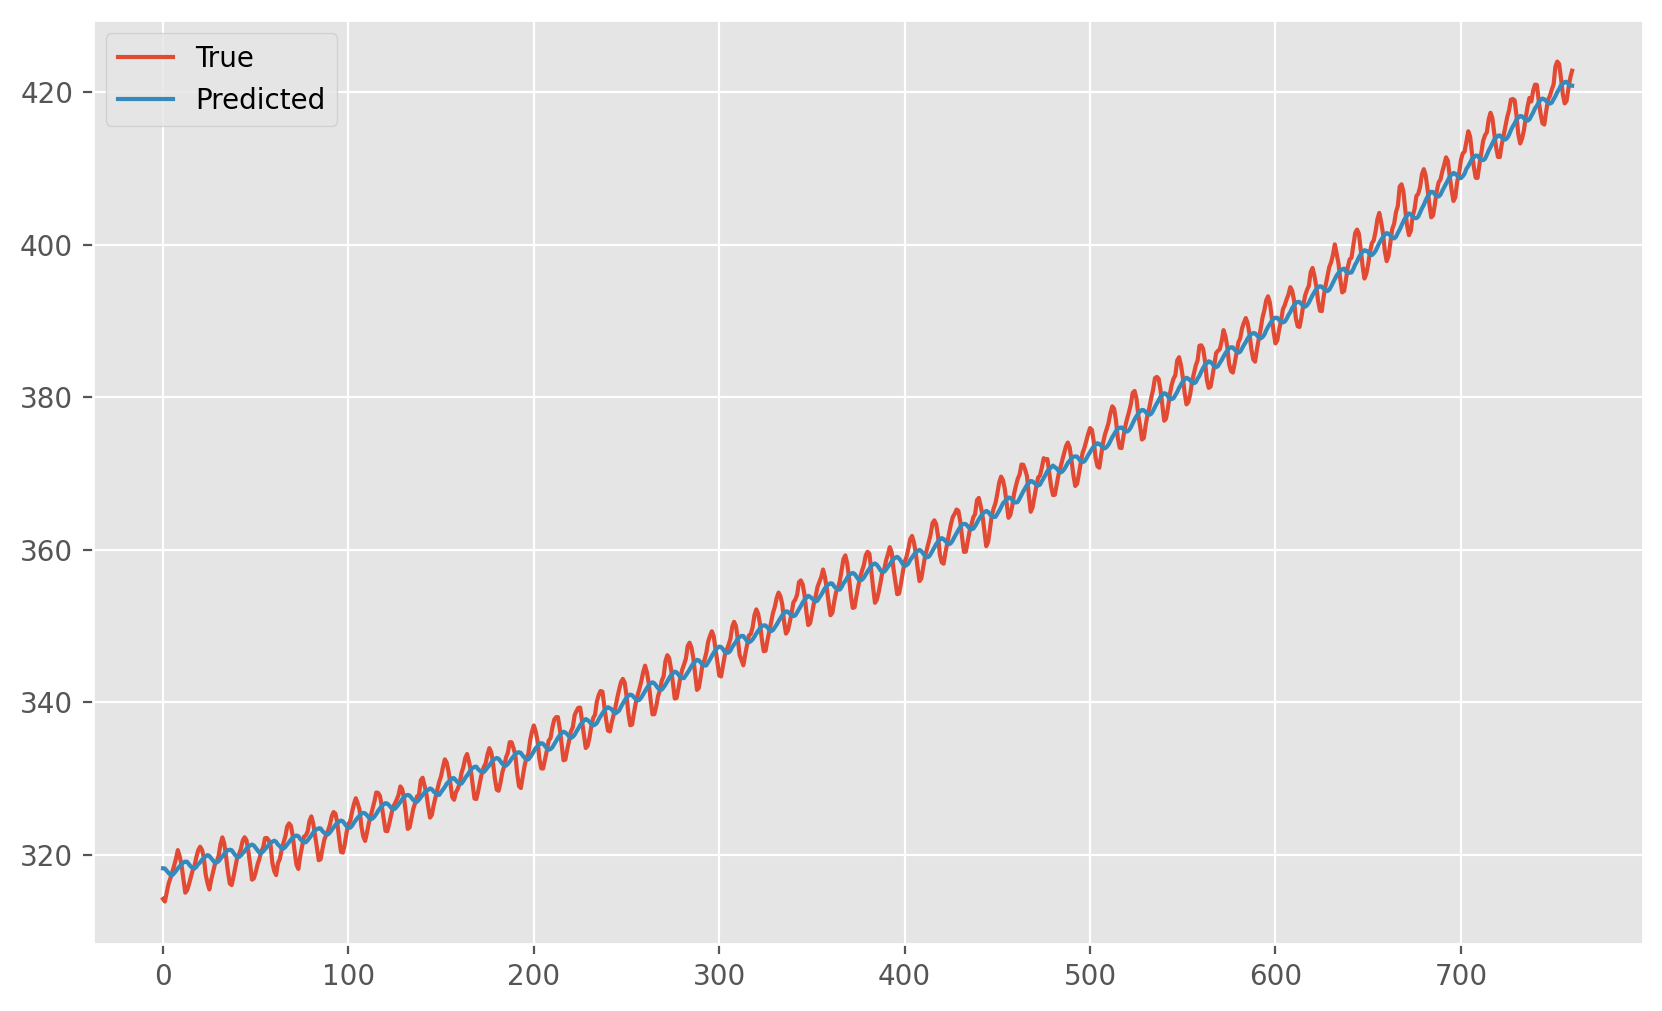

In [335]:
# Predicting on whole data
X_, y_ = dataset(X, y, K, T)
y_pred = mlp(torch.tensor(X_).float()).detach().numpy().flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [336]:
## MSE
y_test_pred = mlp(torch.tensor(X_test_).float()).detach().numpy().flatten()
mse(y_test_, y_test_pred)

7.034043254017696

In [337]:
# ARMA Model
p=27
d=2
q=9
arma_model = ARIMA(y_train, order=(p,d,q))
arma_model_fit = arma_model.fit()

In [338]:
arma_pred = arma_model_fit.predict(start=0, end=len(X)-1)

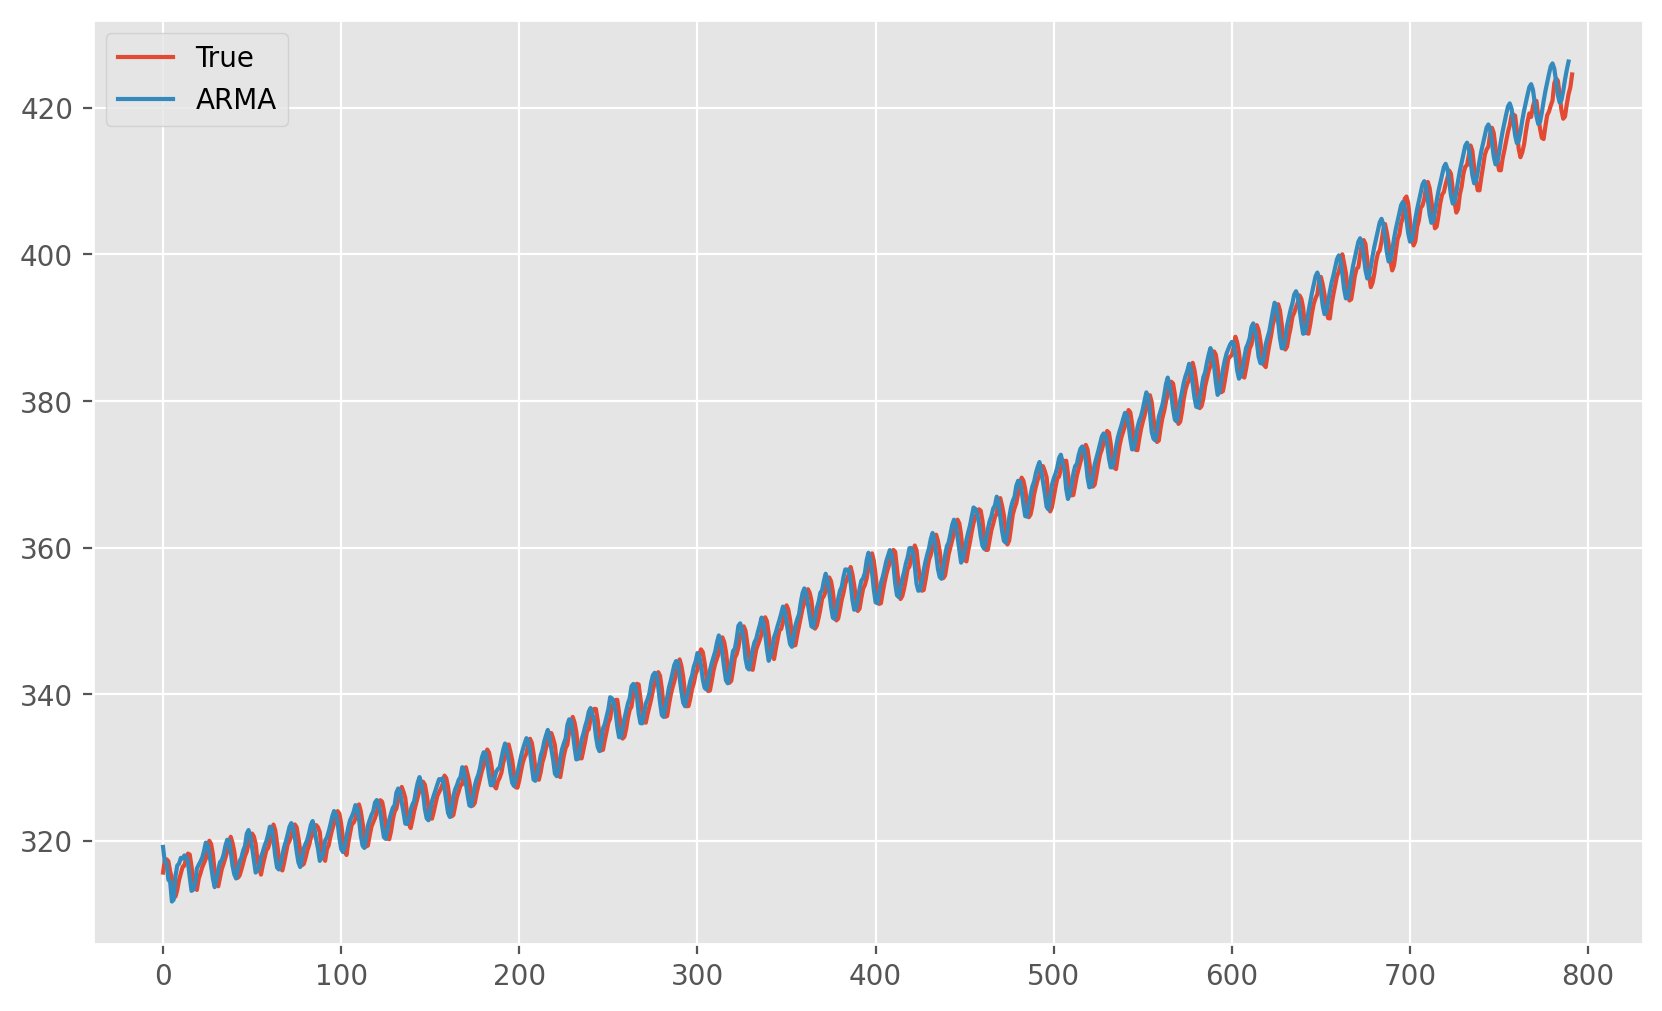

In [339]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='True')
plt.plot(arma_pred[d:], label='ARMA')
plt.legend()
plt.show()


In [340]:
# MSE on test set
mse(y_test, arma_pred[split:])

1.3791649772986665

In [341]:
ma_model = SARIMAX(y_train, order=(0,2,2),seasonal_order=(0,2,1,12))  # MA(2)
ma_model_fit = ma_model.fit()

ma_pred = ma_model_fit.predict(start=0, end=len(X)-1)


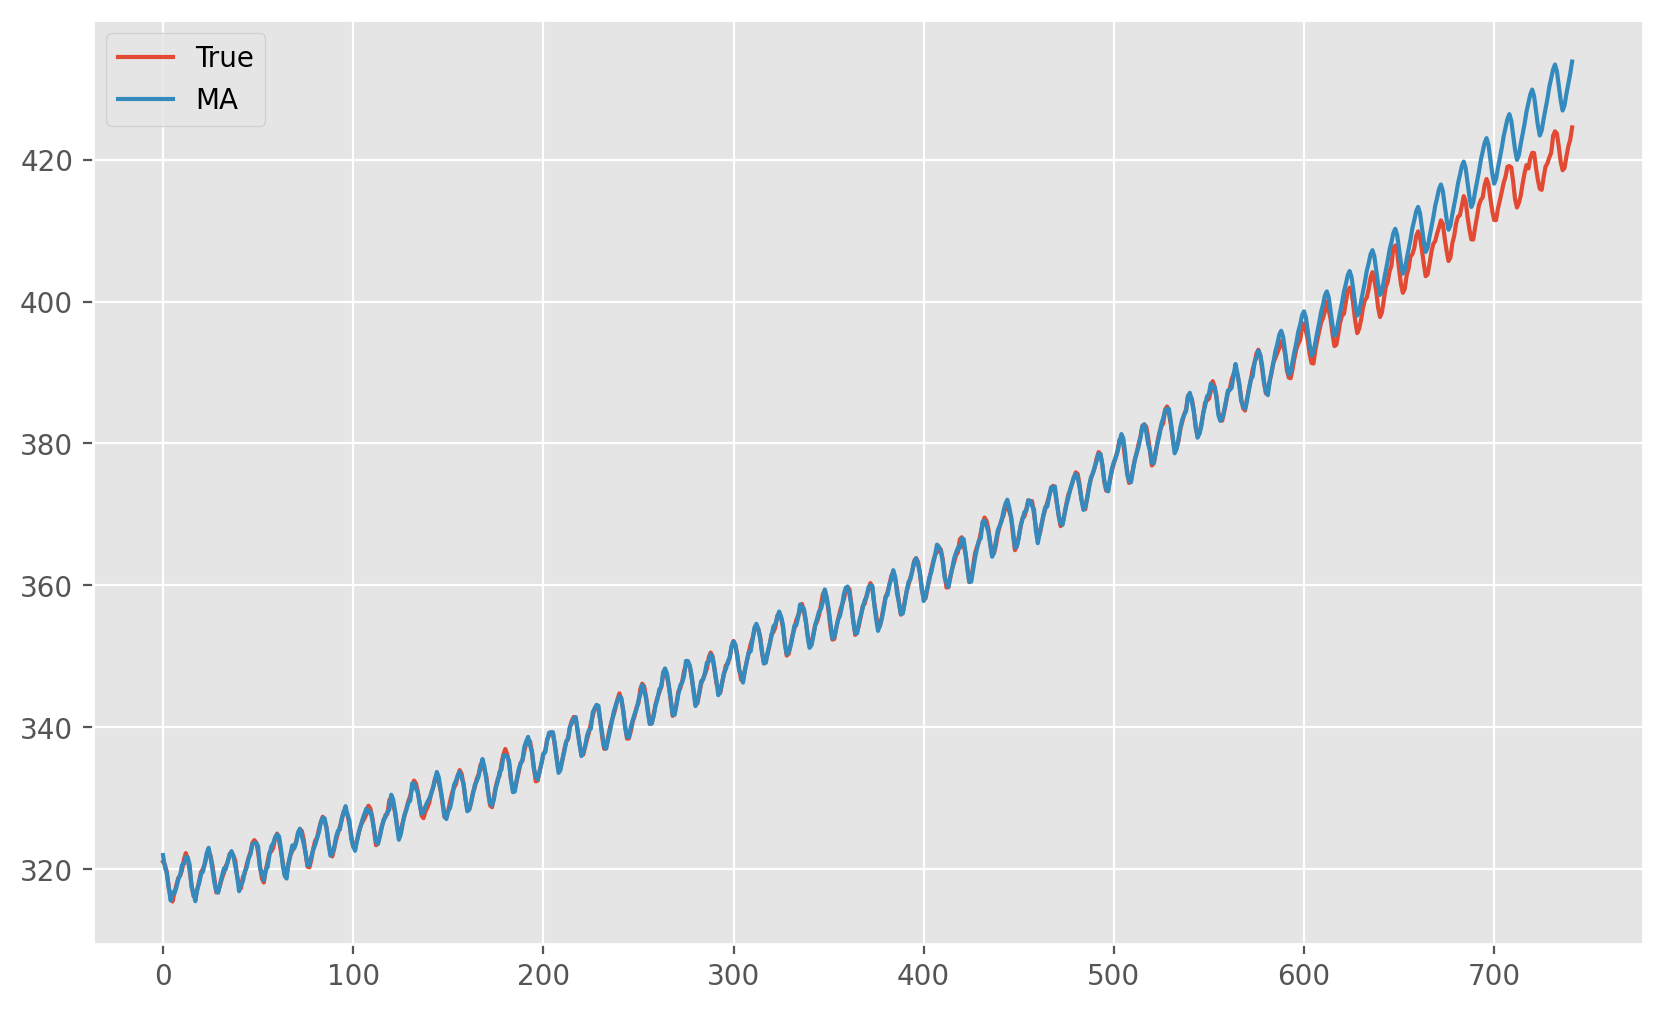

In [342]:
plt.figure(figsize=(10, 6))
plt.plot(y[50:], label='True')
plt.plot(ma_pred[50:], label='MA')
plt.legend()
plt.show()

In [343]:
# MSE on test set
mse(y_test, ma_pred[split:])


24.787741909728997